<center> <h1>Análisis exploratorio de Datos: Transporte en Argentina </h1> </center>

##### Ignacio Jara Balcazar.

## Carga de las librerías a utilizar


In [1]:
!pip install seaborn --upgrade
!pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn import linear_model  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## Procesamiento de datos

Empezamos cargando el dataset: identificamos los tipos de datos con los que tenemos que trabajar y realizamos las correciones necesarias para facilitar el tratamiento de los datos.  

In [3]:
sube_2023 = pd.read_csv("sube-2023.csv")

In [4]:
sube_2023.dtypes #identificamos los datos del dataset

DIA_TRANSPORTE     object
NOMBRE_EMPRESA     object
LINEA              object
AMBA               object
TIPO_TRANSPORTE    object
JURISDICCION       object
PROVINCIA          object
MUNICIPIO          object
CANTIDAD            int64
DATO_PRELIMINAR    object
dtype: object

Observamos que la columna **DIA_TRANSPORTE** contiene datos de fechas pero el programa no reconoce los datos como fechas, para hacer esto utilizamos la funcion to_datatime de Pandas.

In [5]:
sube_2023["DIA_TRANSPORTE"] = pd.to_datetime(sube_2023.DIA_TRANSPORTE) 

In [6]:
sube_2023.dtypes 

DIA_TRANSPORTE     datetime64[ns]
NOMBRE_EMPRESA             object
LINEA                      object
AMBA                       object
TIPO_TRANSPORTE            object
JURISDICCION               object
PROVINCIA                  object
MUNICIPIO                  object
CANTIDAD                    int64
DATO_PRELIMINAR            object
dtype: object

Para comodidad y facilidad de comprensión agregamos la columna **FECHA_DIA** para identificar el día de la semana que corresponde a cada uno de la columna **DIA_TRANSPORTE** aprovechando el tipo fecha

In [7]:
import locale   # Definimos la ubicación e idioma local
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

In [8]:
sube_2023["FECHA_DIA"] = sube_2023["DIA_TRANSPORTE"].dt.strftime('%A') 

In [9]:
sube_2023["FECHA_DIA"] = sube_2023["FECHA_DIA"].replace("sÃ¡bado","sabado").replace("miÃ©rcoles","miercoles").replace("sábado","sabado") #Corregimos los nombres que se asignaron a los días.

In [10]:
sube_2023["FECHA_MES"] = sube_2023["DIA_TRANSPORTE"].dt.strftime('%m')

In [11]:
sube_2023["FECHA_ORDINAL"] = sube_2023["DIA_TRANSPORTE"].dt.strftime('%j') #asigna un número natural a cada día de forma ordenada

In [12]:
sube_2023.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_MES,FECHA_ORDINAL
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,domingo,01,001
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,domingo,01,001
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO,domingo,01,001
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,domingo,01,001
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO,domingo,01,001


Creamos el dataframe _datos_amba_ a partir del dataframe _sube_2023_ donde descartamos datos innecesarios para el análisis solicitado, además reordenamos las columnas para facilitar su entendimiento.

In [13]:
datos_amba = sube_2023.drop(columns = ['NOMBRE_EMPRESA','PROVINCIA','MUNICIPIO','NOMBRE_EMPRESA']) #Descartamos las columnas 

In [14]:
datos_amba = datos_amba[(datos_amba['DATO_PRELIMINAR'] == 'NO') & (datos_amba['AMBA'] == 'SI')] #Filtramos las filas que correspondan a datos preliminares

In [15]:
datos_amba.rename(columns={'DIA_TRANSPORTE': 'FECHA', 'CANTIDAD': 'PASAJEROS'}, inplace=True)
lista_indices = datos_amba.columns.tolist()

print(lista_indices) #Nombre de las columnas

['FECHA', 'LINEA', 'AMBA', 'TIPO_TRANSPORTE', 'JURISDICCION', 'PASAJEROS', 'DATO_PRELIMINAR', 'FECHA_DIA', 'FECHA_MES', 'FECHA_ORDINAL']


In [16]:
orden_nuevo = ["FECHA","FECHA_DIA","FECHA_MES","FECHA_ORDINAL","JURISDICCION","LINEA","PASAJEROS","TIPO_TRANSPORTE"]
datos_amba = datos_amba[orden_nuevo]
datos_amba.tail()

,FECHA,FECHA_DIA,FECHA_MES,FECHA_ORDINAL,JURISDICCION,LINEA,PASAJEROS,TIPO_TRANSPORTE
472214,2023-12-31,domingo,12,365,MUNICIPAL,LINEA_552_BSAS,4189,COLECTIVO
472216,2023-12-31,domingo,12,365,MUNICIPAL,LINEA_553_BSAS,5229,COLECTIVO
472238,2023-12-31,domingo,12,365,NaN,LINEA_A,30931,SUBTE
472242,2023-12-31,domingo,12,365,NaN,LINEA_B,34714,SUBTE
472274,2023-12-31,domingo,12,365,MUNICIPAL,NORTE MUNICIPAL,2819,COLECTIVO


Ahora identificamos de estos datos: 
   - __(a)__ proporción de cantidad total de pasajeros que le corresponde a cada transporte
   - __(b)__ la tupla (mes,linea de subte) donde viajó la mayor cantidad de pasajeros 
   - __(c)__ el día hábil con menor desvío estándar en cantidad de pasajeros

###  _(a)_

In [17]:
total_pasajeros = datos_amba["PASAJEROS"].sum()
pasajeros_por_transporte = datos_amba.groupby("TIPO_TRANSPORTE")["PASAJEROS"].sum()

Proporcion = pasajeros_por_transporte / total_pasajeros 
Proporcion

TIPO_TRANSPORTE
COLECTIVO    0.837645
SUBTE        0.068097
TREN         0.094258
Name: PASAJEROS, dtype: float64

### _(b)_

In [18]:
pasajeros_subte = datos_amba[datos_amba["TIPO_TRANSPORTE"] == "SUBTE"]

pasajeros_por_mes_y_linea = pasajeros_subte.groupby(["FECHA_MES","LINEA"])["PASAJEROS"].sum()
tupla_max = pasajeros_por_mes_y_linea.idxmax()
tupla_max

('08', 'LINEA_B')

### _(c)_

In [19]:
datos_amba_habiles = datos_amba[(datos_amba['FECHA_DIA'] != "domingo") & (datos_amba['FECHA_DIA'] != "sabado")]

desvios_dias_habiles = datos_amba_habiles.groupby("FECHA_DIA")["PASAJEROS"].std()

menor_desvio_dia = desvios_dias_habiles.idxmin()
menor_desvio_dia

'lunes'

---------------------------------------------------------------------------

# Análisis Exploratorio

### Revisamos el dataframe _sube_2023_ 

 Primero nos fijamos si el dataframe presenta datos faltantes y analizamos algunos parámetros estadísticos.

In [20]:
sube_2023.duplicated().sum() #Cantidad de duplicados

0

In [21]:
sube_2023.isnull().sum() #observamos si hay datos nulos

DIA_TRANSPORTE        0
NOMBRE_EMPRESA        0
LINEA                 0
AMBA                  0
TIPO_TRANSPORTE       0
JURISDICCION       2549
PROVINCIA          2571
MUNICIPIO          2571
CANTIDAD              0
DATO_PRELIMINAR       0
FECHA_DIA             0
FECHA_MES             0
FECHA_ORDINAL         0
dtype: int64

Notamos que hay datos faltantes en las columnas **JURISDICCIÓN**, **PROVINCIA** y **MUNICIPIO** ya que estos corresponden a los viajes en subte. 

In [22]:
sube_2023.describe().T #obtenemos parámetros estadísticos

,count,mean,std,min,25%,50%,75%,max
CANTIDAD,472291.0,9336.927454,20609.074234,-417.0,683.0,2627.0,9062.0,542616.0


In [23]:
sube_2023.describe(include='O').T 

,count,unique,top,freq
NOMBRE_EMPRESA,472291,321,AUTOTRANSPORTES EL TRAPICHE SRL Y TRANSPORTE G...,22704
LINEA,472291,1492,LINEA 1,2704
AMBA,472291,2,NO,322277
TIPO_TRANSPORTE,472291,4,COLECTIVO,461768
JURISDICCION,469742,3,PROVINCIAL,218648
PROVINCIA,469720,20,BUENOS AIRES,132117
MUNICIPIO,469720,93,SN,218648
DATO_PRELIMINAR,472291,2,NO,472223
FECHA_DIA,472291,7,miércoles,70432
FECHA_MES,472291,12,10,41380


### ANÁLISIS BREVE DE PARÁMETROS ESTADÍSTICOS:

En base a las métricas observadas anteriormente se puede intuir lo siguiente:

- De la variable tenemos valores negativos
- Investigar la variable PROVINCIA puesto que en Argentina se divide en 23 provincias y JN (se incluye como provincia), en este caso contamos solo 20. 
- Observar que el dataframe puede contener datos preliminares (hay una variable distinta a "NO") 

In [24]:
#solucionar valores negativos
sube_2023 = sube_2023[sube_2023 ["CANTIDAD"] >= 0]

## ¿Cómo evoluciona el uso del transporte público durante el año 2023?

In [25]:
sube_2023["FECHA_ORDINAL"] = sube_2023["FECHA_ORDINAL"].astype(int)

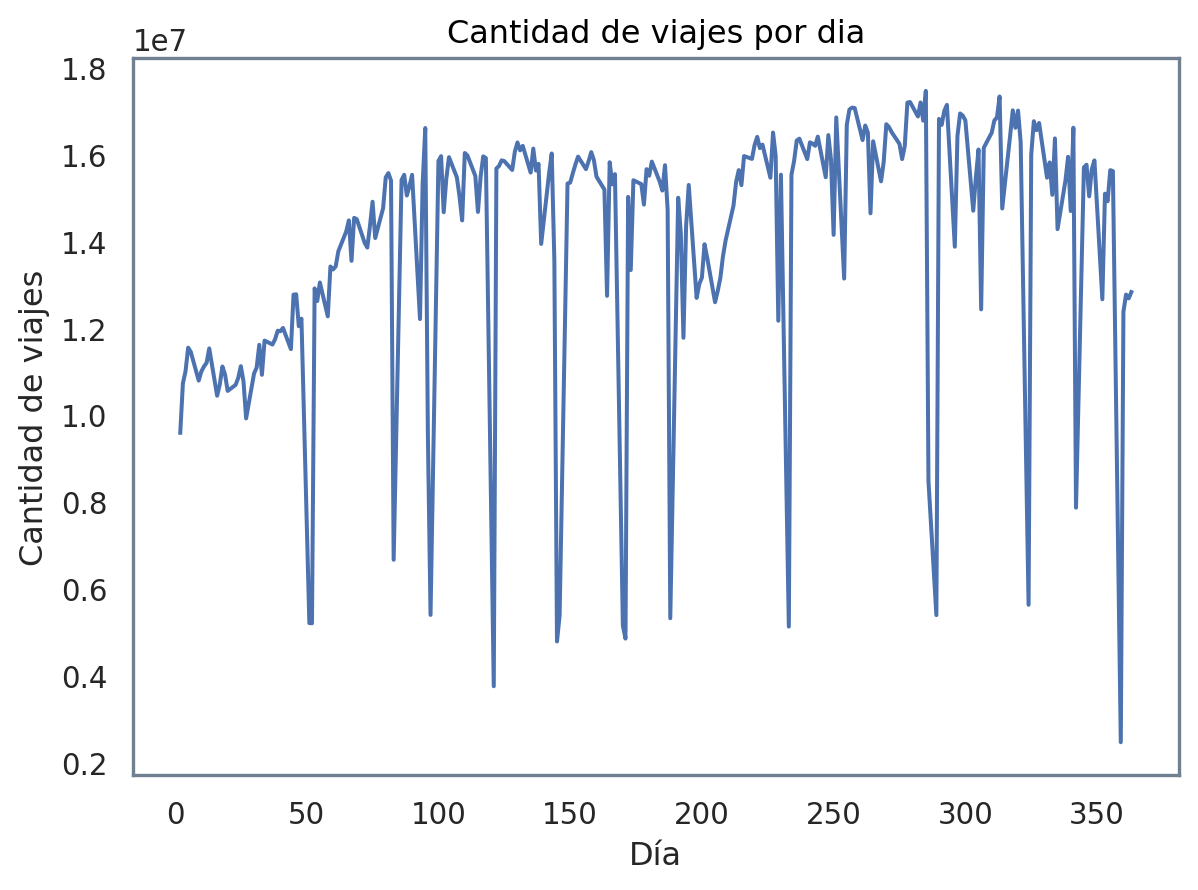

In [26]:
#Cuánto se usa el transporte público al año en toda Argentina por día , para sacar outliers filtramos por días hábiles
viajes_anual = sube_2023[(sube_2023["FECHA_DIA"] != 'domingo') & (sube_2023['FECHA_DIA'] != 'sabado')]
viajes_anual1 = viajes_anual.groupby(["FECHA_ORDINAL","FECHA_DIA","FECHA_MES"])["CANTIDAD"].sum()
viajes_anualdf = viajes_anual1.to_frame().reindex()
(
so.Plot(data = viajes_anualdf, x = "FECHA_ORDINAL", y = "CANTIDAD")
    .add(so.Lines())
    .label( title = "Cantidad de viajes por dia", x = "Día", y = "Cantidad de viajes")
    .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
)

 Observamos que, a pesar de haber filtrado por días hábiles, hay outliers que pueden corresponderse a días feriados y paros. 

## ¿Y cómo es la evolución mensual?

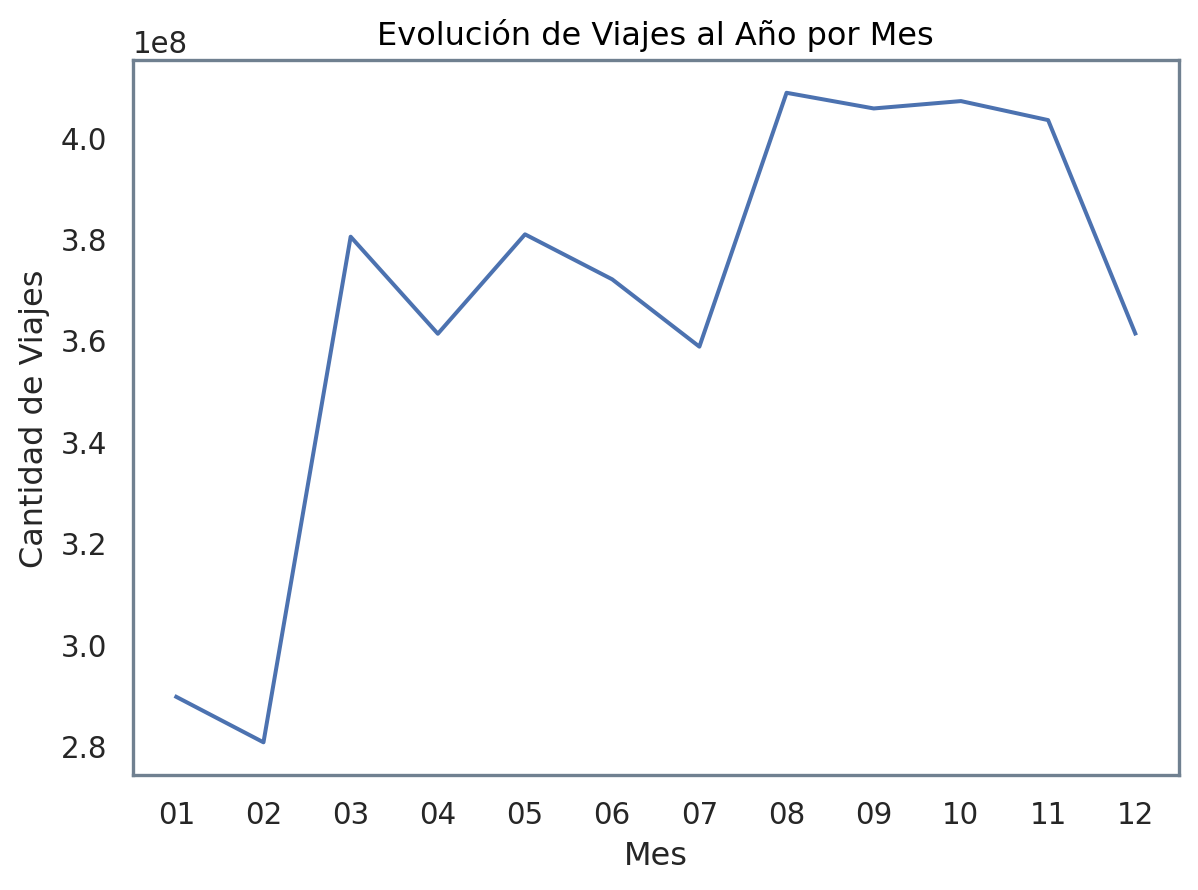

In [27]:
#Cuanto se viaja al año por mes en toda Argentina
viajes_anual_mes = sube_2023.groupby(["FECHA_MES"])["CANTIDAD"].sum()
viajes_anual_mesdf = viajes_anual_mes.to_frame()
(
    so.Plot(data = viajes_anual_mesdf, x = "FECHA_MES", y = "CANTIDAD")
    .add(so.Lines())
    .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
    .label(title = "Evolución de Viajes al Año por Mes", x = "Mes", y = "Cantidad de Viajes") 
)

 De este gráfico podemos observar que el uso del transporte público varía a lo largo del año, teniendo un mínimo en el mes de febrero y un máximo en agosto. Correspondiendose estas fechas con recesos de verano y un mínimo en invierno también   

## ¿Cómo varía el uso por provincia durante el 2023?

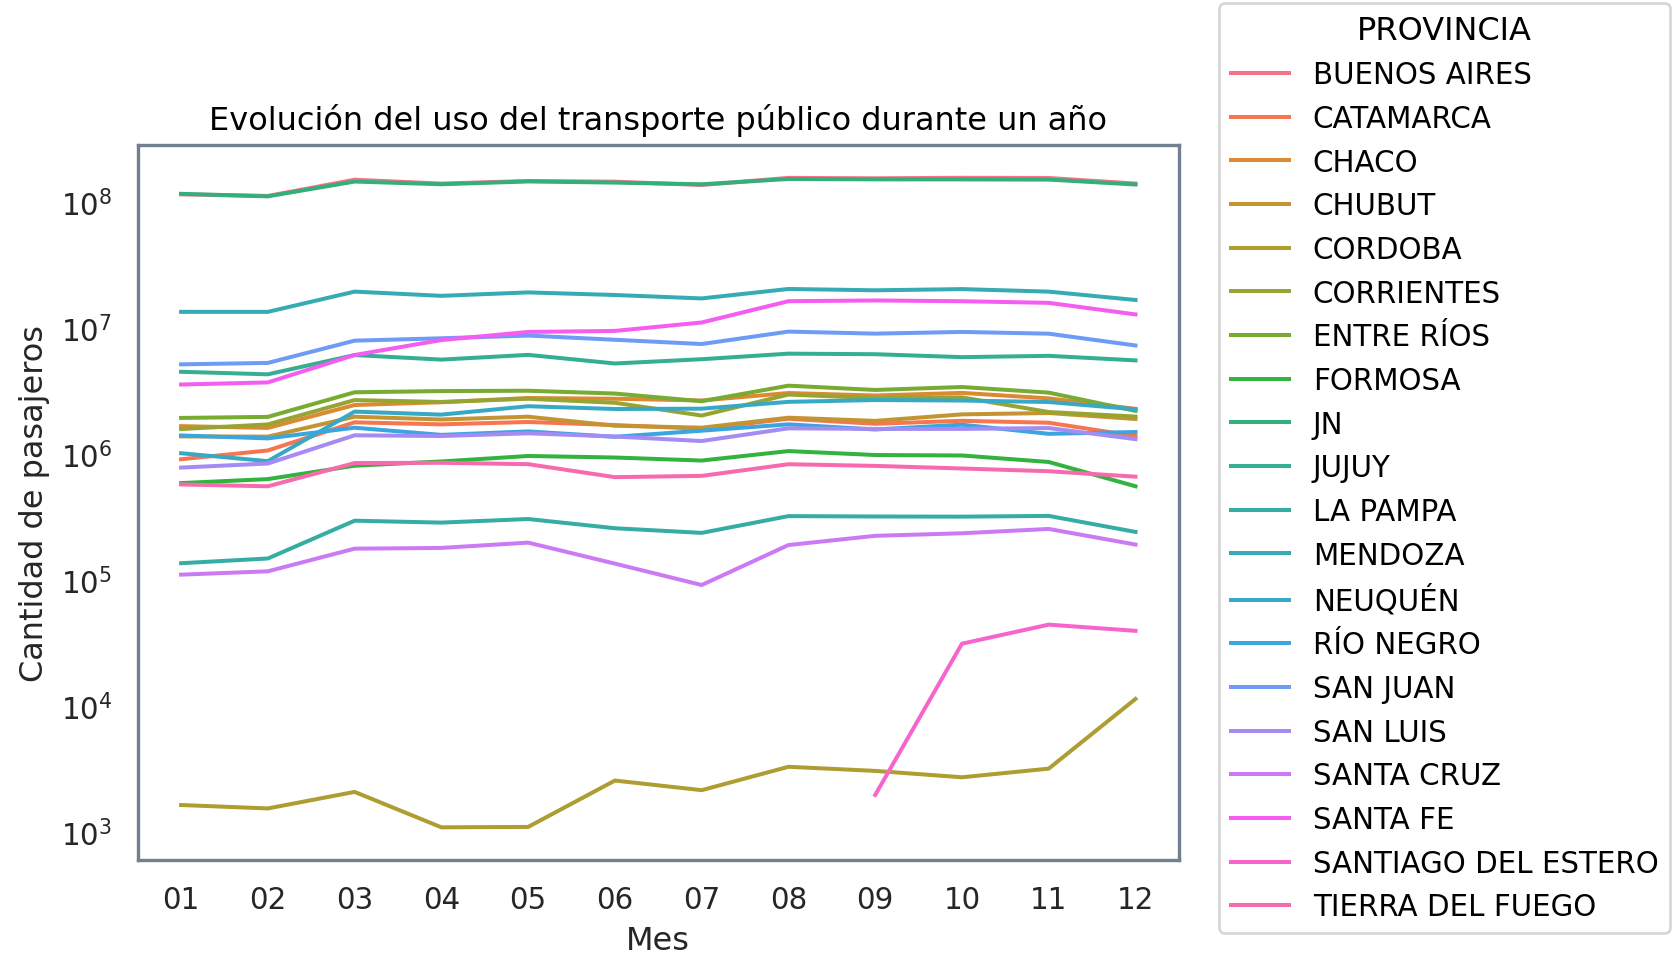

In [28]:
sube_provincias = sube_2023.groupby(["PROVINCIA","FECHA_MES"])["CANTIDAD"].sum().reset_index()## Creamos un dataframe que contenga los pasajeros totales agrupados por dia y provincia
(
so.Plot(data = sube_provincias, x = "FECHA_MES", y = "CANTIDAD", color = "PROVINCIA")
        .add(so.Lines())
        .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
        .scale(y = "log")
        .label(title = "Evolución del uso del transporte público durante un año", x = "Mes", y = "Cantidad de pasajeros")
)

Del grafico se puede observar que no hay datos de Santiago del Estero hasta Septiembre del 2023, esto tiene sentido puesto que la provincia implementó el sistema SUBE durante ese período de tiempo. También
se observan datos incongruentes con la realidad con respecto a la provincia de Córdoba, puesto que la población de esta provincia es mayor que otras como Jujuy o Rio Negro. Asumimos que hubo un error de medición.

## ¿Cómo se distribuyen los viajes a lo largo de la semana?, ¿Qué día se viaja más?

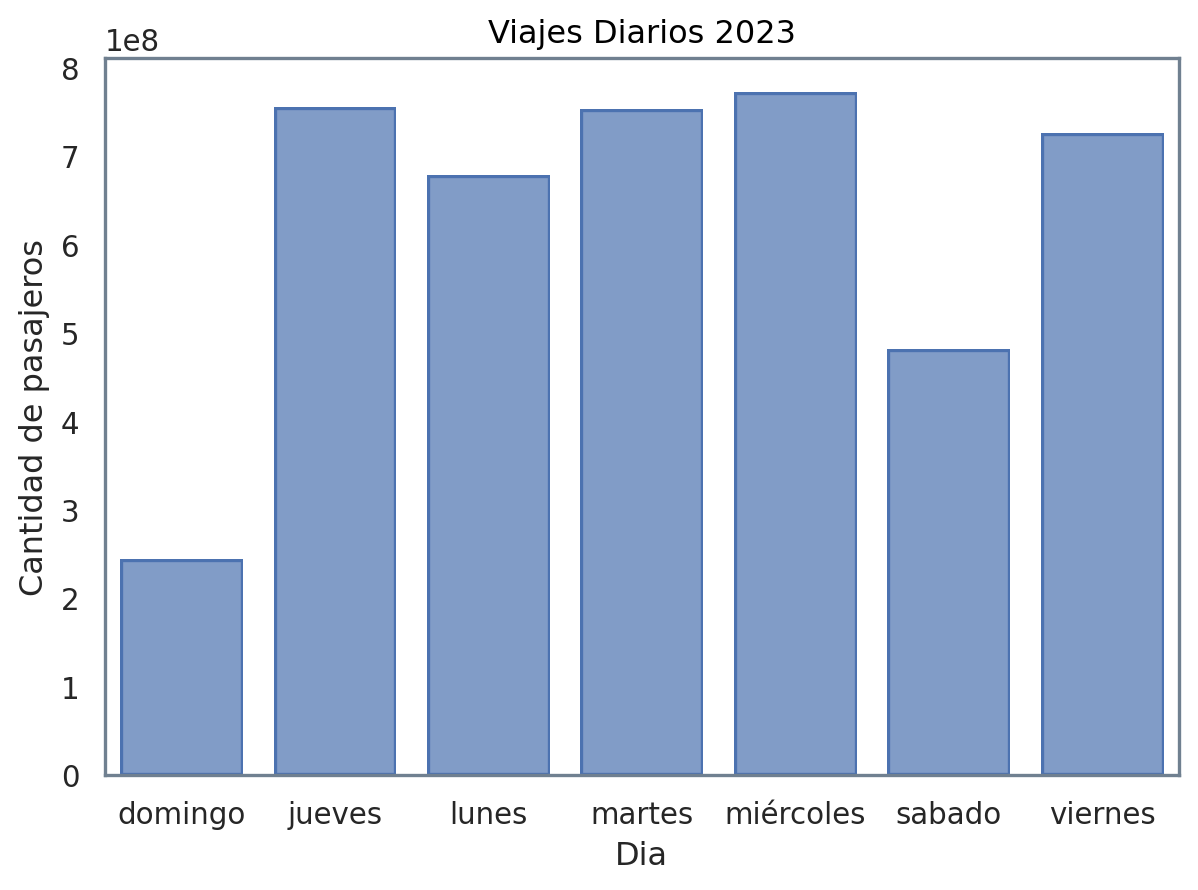

In [29]:
sube_viajes_dia = sube_2023.groupby("FECHA_DIA")["CANTIDAD"].sum().reset_index() ##Creamos un dataframe que contenga dia junto a los pasajeros totales
(
so.Plot(data = sube_viajes_dia,x = "FECHA_DIA", y = "CANTIDAD")
    .add(so.Bar())
    .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
    .label(title = "Viajes Diarios 2023", x = "Dia", y = "Cantidad de pasajeros")
)

Tal como se espera el uso de los transportes decae durante los fines de semana en comparacion con los dias habiles y mas aun el domingo siendo que gran parte de la poblacion trabaja los sabados

Ahora queriamos ver si los tres medios de transporte si se comportan igual a lo largo de los dias

## ¿Cómo se usan los distintos medios de transporte según día de la semana?

In [30]:
scaler = MinMaxScaler().set_output(transform="pandas")
orden = (2,3,4,1,6,5,0)
sube_transportes = sube_2023.groupby(["TIPO_TRANSPORTE","FECHA_DIA"])["CANTIDAD"].sum().reset_index()
sube_transportes = sube_transportes.pivot(index = "FECHA_DIA", columns = "TIPO_TRANSPORTE", values = "CANTIDAD").reset_index()
sube_transportes = sube_transportes.reindex(orden).reset_index().drop(columns = "index")
d = ["COLECTIVO","SUBTE","TREN","LANCHAS"]
sube_transportes_escalado = scaler.fit_transform(sube_transportes[d])
sube_transportes_escalado["FECHA_DIA"] = pd.DataFrame({"FECHA_DIA":["LUNES","MARTES","MIERCOLES","JUEVES","VIERNES","SABADO","DOMINGO"]})
sube_transportes_escalado = sube_transportes_escalado.melt(id_vars = ["FECHA_DIA"], var_name = "TIPO_TRANSPORTE", value_name = "CANTIDAD")

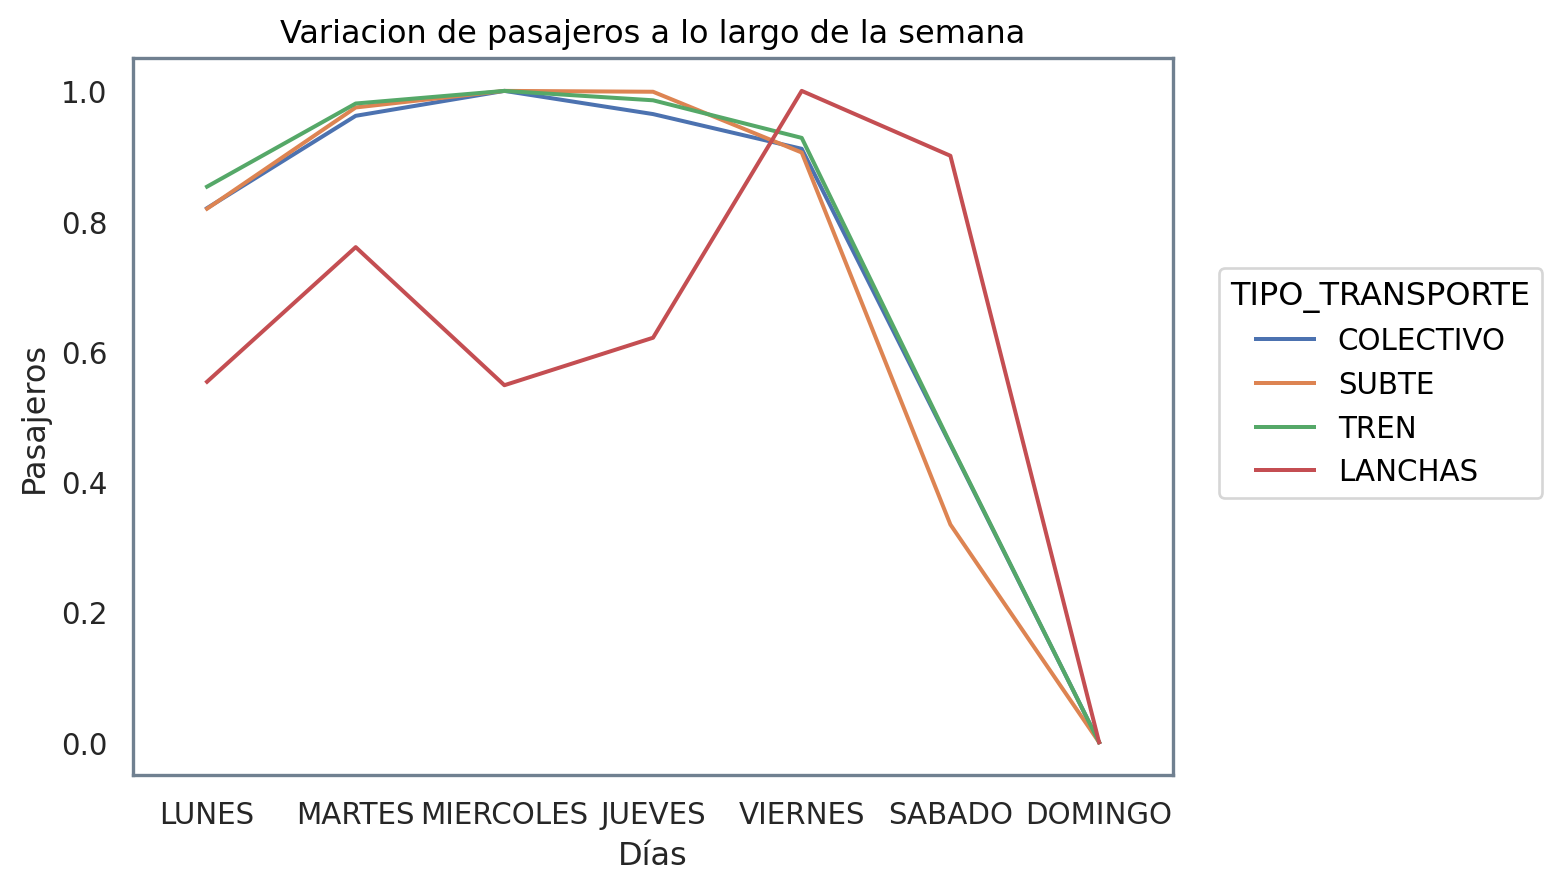

In [31]:
(
    so.Plot(data = sube_transportes_escalado, x = "FECHA_DIA", y = "CANTIDAD", color = "TIPO_TRANSPORTE")
    .add(so.Lines())
    .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
    .label(title = "Variacion de pasajeros a lo largo de la semana", x = "Días", y = "Pasajeros")
)

Las lineas parecen seguir el mismo comportamiento en todos los medios de transporte masivos, se observa que las lanchas aumentan su uso los fines de semana a diferencia del resto de medios de transporte, se debe a que su uso suele estar asociado a actividades de ocio.

## ¿Qué provincias usan más el transporte público?

In [32]:
poblacion_2023 = pd.read_csv("poblacion_identificada_provincia_enero_2023.csv")
poblacion_2023 = poblacion_2023.drop(columns = ["nacionalidad","edad_quinquenal","pais_de_nacimiento"])
poblacion_2023 = poblacion_2023.groupby(["provincia_nombre"])["cantidad"].sum().reset_index()
Indec = set(poblacion_2023.provincia_nombre.str.upper())
sube = set(sube_2023.PROVINCIA.unique())

In [33]:
sube - Indec

{'ENTRE RÍOS', 'JN', 'NEUQUÉN', 'RÍO NEGRO', nan}

In [34]:
provs = pd.Series(sube_2023.PROVINCIA.unique())
provs.str.replace("Í", "I").str.replace("É", "E")

0            BUENOS AIRES
1                      JN
2                  CHUBUT
3                     NaN
4                SANTA FE
5              ENTRE RIOS
6                LA PAMPA
7                 MENDOZA
8               RIO NEGRO
9        TIERRA DEL FUEGO
10                  CHACO
11                  JUJUY
12                NEUQUEN
13                FORMOSA
14             CORRIENTES
15              CATAMARCA
16               SAN JUAN
17               SAN LUIS
18                CORDOBA
19             SANTA CRUZ
20    SANTIAGO DEL ESTERO
dtype: object

In [36]:
poblacion_2023_upper = poblacion_2023
poblacion_2023_upper["provincia_nombre"] = provs
poblacion_2023_upper = poblacion_2023_upper.dropna()
poblacion_2023_upper = poblacion_2023_upper.rename(columns={"provincia_nombre":"PROVINCIA"})

In [37]:
sube_provincias_viajes = sube_2023.groupby(["PROVINCIA","FECHA_ORDINAL"])["CANTIDAD"].sum()
sube_provincias_viajes = pd.DataFrame(sube_provincias_viajes.groupby(["PROVINCIA"]).mean().reset_index())

In [39]:
pLaTeXrovincia_poblacion_viajes = sube_provincias_viajes.merge(poblacion_2023_upper, on = "PROVINCIA")
provincia_poblacion_viajes = provincia_poblacion_viajes.rename(columns={"CANTIDAD":"MEDIANA*DIA*PASAJEROS","cantidad":"HABITANTES"})
provincia_poblacion_viajes = provincia_poblacion_viajes[provincia_poblacion_viajes["PROVINCIA"] != "JN"]
provincia_poblacion_viajes["%PASAJEROS"] = (provincia_poblacion_viajes["MEDIANA*DIA*PASAJEROS"]/provincia_poblacion_viajes["HABITANTES"])*100

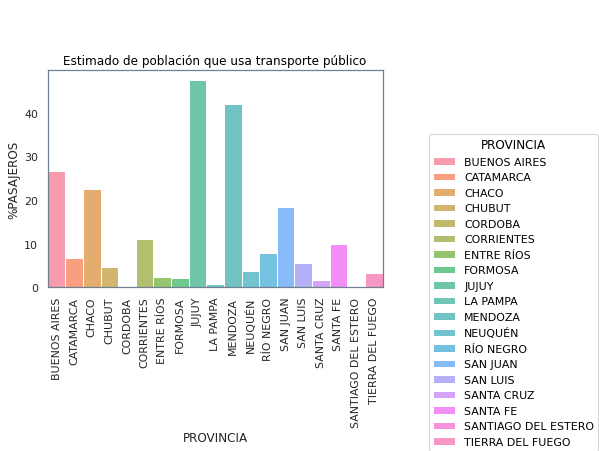

In [40]:
fig = plt.figure()
(
    so.Plot(data = provincia_poblacion_viajes, x = "PROVINCIA", y = "%PASAJEROS", color = "PROVINCIA")
    .add(so.Bars())
    .label(title = "Estimado de población que usa transporte público")
    .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
    .on(fig)
    .plot()
)
for ax in fig.axes:
    ax.tick_params("x", rotation=90)

 Se puede observar que las provincias (sin contar JN) que más porcentaje de pasajeros tienen según su población son Jujuy y Mendoza.

## ¿Existe una relación entre cantidad de lineas por provincia y cantidad de habitantes?

In [41]:
sube_lineas = pd.DataFrame(sube_2023.groupby(["PROVINCIA"])["LINEA"].nunique()).reset_index()
provincia_lineas_poblacion = sube_lineas.merge(poblacion_2023_upper, on = "PROVINCIA")
provincia_lineas_poblacion["LINEAS*HABITANTE"] = (provincia_lineas_poblacion["LINEA"]/provincia_lineas_poblacion["cantidad"])
provincia_lineas_poblacion = provincia_lineas_poblacion.rename(columns={"cantidad":"HABITANTES","LINEA":"LINEAS"})

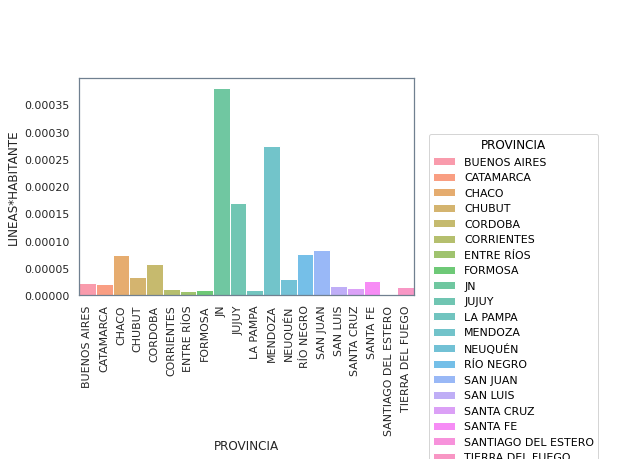

In [42]:
fig = plt.figure()
(
    so.Plot(data = provincia_lineas_poblacion, x = "PROVINCIA", y = "LINEAS*HABITANTE", color = "PROVINCIA")
    .add(so.Bars())
    .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
    .on(fig)
    .plot()  
)
for ax in fig.axes:
    ax.tick_params("x", rotation=90)

------------------------------------

De observar el gráfico podemos concluir que no parece existir una relacion directa entre cantidad de lineas y cantidad de habitantes, ya que, por ejemplo, Buenos Aires y Santiago Del Estero tienen muchos habitantes y no se observa que la cantidad de lineas tenga una relación directa. 

## Modelado

In [43]:
sube_2023_regresion = pd.read_csv("sube-2023-regresion.csv")
sube_2023_regresion["DIA_TRANSPORTE"] = pd.to_datetime(sube_2023_regresion.DIA_TRANSPORTE)
datos_amba_regresion = sube_2023_regresion[(sube_2023_regresion["PROVINCIA"] == "JN")&(sube_2023_regresion["AMBA"] == "SI")&(sube_2023_regresion["TIPO_TRANSPORTE"] == "COLECTIVO")]
cols = datos_amba_regresion.LINEA.unique()
pasajeros_por_linea = pd.DataFrame()
for col in cols:
    datos_linea = datos_amba_regresion[datos_amba_regresion.LINEA == col ][["DIA_TRANSPORTE", "CANTIDAD"]]
    datos_linea = datos_linea.set_index("DIA_TRANSPORTE").rename(columns ={"CANTIDAD" : col })
    pasajeros_por_linea = pd.concat ([pasajeros_por_linea,datos_linea ], axis = 1)

In [44]:
#chequear faltantes y sacar las columnas con datos faltantes
columnas_con_faltantes = pasajeros_por_linea.columns[pasajeros_por_linea.isnull().any()]
pasajeros_por_linea = pasajeros_por_linea.drop(columns = columnas_con_faltantes)
pasajeros_por_linea.isnull().sum()

BS_ASLINEA_123    0
BSAS_LINEA_002    0
BSAS_LINEA_009    0
BSAS_LINEA_010    0
BSAS_LINEA_015    0
                 ..
LINEA 7           0
LINEA 76          0
LINEA 8           0
LINEA_099         0
LINEA_164_AMBA    0
Length: 124, dtype: int64

##### Separo el conjunto de testeo y entrenamiento al principio para evitar usar en el entrenamiento datos del conjunto de testeo

In [45]:
pasajeros_por_linea_train, pasajeros_por_linea_test = train_test_split(pasajeros_por_linea, test_size=0.2, random_state=45)
pasajeros_por_linea_train.shape

(200, 124)

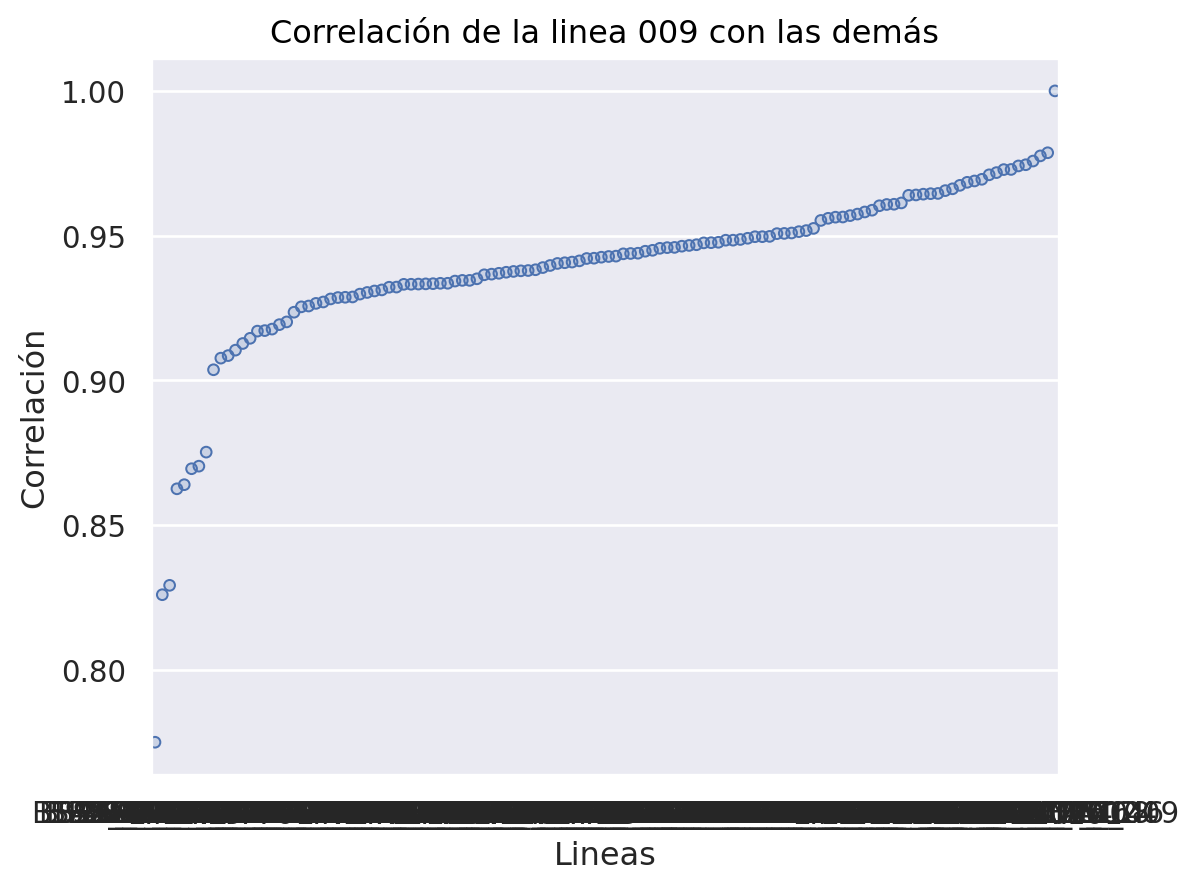

In [46]:
#busco las lineas con mayor correlación
correlacion_9 = pasajeros_por_linea_train.corr().BSAS_LINEA_009.to_frame().sort_values("BSAS_LINEA_009")
(
so.Plot(data= correlacion_9, x = correlacion_9.index, y = "BSAS_LINEA_009")
    .add(so.Dots())
    .label(title = "Correlación de la linea 009 con las demás", x ="Lineas" , y = "Correlación")
)

In [47]:
correlacion_9 = correlacion_9[correlacion_9["BSAS_LINEA_009"]>0.95]
correlacion_9

,BSAS_LINEA_009
BSAS_LINEA_067,0.950663
BSAS_LINEA_174,0.950740
BSAS_LINEA_130,0.950882
BSAS_LINEA_127,0.951351
BSAS_LINEA_108,0.951716
BSAS_LINEA_021,0.952475
BSAS_LINEA_111,0.955223
BSAS_LINEA_060,0.955963
BSAS_LINEA_152,0.956352
BSAS_LINEA_126,0.956409


 Para entrenar los modelos tomo las lineas que tengan mayor correlación con la linea 09

In [48]:
#regresion lineal de una sola variable

modelo1 = linear_model.LinearRegression() 
modelo1.fit(pasajeros_por_linea_train[['BSAS_LINEA_146']], pasajeros_por_linea_train[['BSAS_LINEA_009']])

#coeficientes del modelo
beta_1m1 = modelo1.coef_   
beta_0m1 = modelo1.intercept_

y_pred1 = modelo1.predict(pasajeros_por_linea_test[['BSAS_LINEA_146']])
r21 = r2_score(pasajeros_por_linea_test[['BSAS_LINEA_009']], y_pred1)
print("El valor de R^2 del modelo 1 es:",r21)

El valor de R^2 del modelo 1 es: 0.9355989265829913


In [49]:
#regresion lineal con cinco demas variables (lineas)

modelo2 = linear_model.LinearRegression()  
modelo2.fit(pasajeros_por_linea_train[['BSAS_LINEA_024', 'BSAS_LINEA_128', 'BSAS_LINEA_168', 'BSAS_LINEA_100', 'BSAS_LINEA_146']], pasajeros_por_linea_train[['BSAS_LINEA_009']])

beta_1m2 = modelo2.coef_   
beta_0m2 = modelo2.intercept_ 

y_pred2 = modelo2.predict(pasajeros_por_linea_test[['BSAS_LINEA_024', 'BSAS_LINEA_128', 'BSAS_LINEA_168', 'BSAS_LINEA_100', 'BSAS_LINEA_146']])

r22 = r2_score(pasajeros_por_linea_test[['BSAS_LINEA_009']], y_pred2)
print("El valor de R^2 del modelo 2 es:", r22)

El valor de R^2 del modelo 2 es: 0.9371257349622361


In [50]:
# regresion ridge para las mismas cinco lineas, primero busco el alpha que mejor aproxime usando un esquema de validación cruzada

alphas = [0.1,10, 100, 10_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000, 10_000_000_000]
scores = []
for alpha in alphas:
    modelo_ridge = linear_model.Ridge(alpha=alpha)
    score = cross_val_score(modelo_ridge, pasajeros_por_linea_train[['BSAS_LINEA_024', 'BSAS_LINEA_128', 'BSAS_LINEA_168', 'BSAS_LINEA_100', 'BSAS_LINEA_146']], pasajeros_por_linea_train[['BSAS_LINEA_009']], cv=5, scoring='r2') 
    scores.append(np.mean(score))
scores

[0.9560181951156208,
 0.9560181952601841,
 0.9560181965743958,
 0.9560183411239688,
 0.9560326605256029,
 0.9561515782767482,
 0.9567570161362016,
 0.9567677161621295,
 0.9450583550047946]

Como se puede ver, el valor de $\alpha$ óptimo es muy alto, siendo el elegido para nuestro modelo $\alpha = 1.000.000.000$. Esto se debe a que no hemos estandarizado los valores de las variables (que se mueven en las decenas de miles) y a que los coeficientes $\beta$ son menores a 1, lo cual genera que el término de regularización de la optimización sea demasiado pequeño como para impactar en el error total y por tanto en la estimación de los coeficientes. Esto da como resultado que para $\alpha$ entre 0 y 10.000.000 el modelo sea prácticamente idéntico y por tanto también lo sean sus $R^2$

Esto no representa ningún problema para el modelo, pero es importante tenerlo en consideración.

In [51]:
modelo3 = Ridge(alpha=1_000_000_000)
modelo3.fit(pasajeros_por_linea_train[['BSAS_LINEA_024', 'BSAS_LINEA_128', 'BSAS_LINEA_168', 'BSAS_LINEA_100', 'BSAS_LINEA_146']], pasajeros_por_linea_train[['BSAS_LINEA_009']])

beta_1m3 = modelo3.coef_   
beta_0m3 = modelo3.intercept_ 

y_pred3 = modelo3.predict(pasajeros_por_linea_test[['BSAS_LINEA_024', 'BSAS_LINEA_128', 'BSAS_LINEA_168', 'BSAS_LINEA_100', 'BSAS_LINEA_146']])

r23 = r2_score(pasajeros_por_linea_test[['BSAS_LINEA_009']], y_pred3)
print("El valor de R^2 del modelo 3 es:", r23)

El valor de R^2 del modelo 3 es: 0.9359872984455188


Elegimos el modelo 2 por ser el que tiene mayor $R^2$ en el set de validación.

La expresión final del modelo entonces es:

$$
\hat{Y} = 0,2347 \cdot X_1 - 0,1716 \cdot X_2 + 0,239 \cdot X_3 + 0,074 \cdot X_4 + 0,4385 \cdot X_5
$$

Donde $X_i$ es un vector con la cantidad por día de pasajeros para cada una de las lineas **24**, **128**, **168**,**100** y **146**, en ese orden
e $\hat{Y}$ es el vector estimado de pasajeros por día de la linea **9**.